In [4]:
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import backend as K
from keras.layers import Dense, Flatten, InputLayer, Conv2D, Conv2DTranspose, MaxPool2D
from keras.layers import Dropout, GaussianNoise
from keras import Sequential, Model
from sklearn.utils import compute_class_weight
import os
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
from keras.preprocessing.image import ImageDataGenerator
import tied_convolution
from tied_convolution import Conv2DTranspose_tied

class CAE_classifier:
    """ 
    Class to build and train combined autoencoder and classifier networks.

    --MAIN METHODS--

    build_autoencoder():
      Method to build the encoder and autoencoder networks.
      The encoder is passed as a layer to the autoencoder and classifier networks,
      so to access the layers within the encoder block, use autoencoder.layers[0].layers
      > Gets called when an instance of the class is created.

    train_autoencoder(x_train,x_test):
      Method to train the autoencoder. The input data and target data is the same,
      since the goal is to reconstruct the input. Data shape has to be (-1,) + input_shape

    build_classifier(pretrained = True):
      Method to build a classifer model. 
      If the pretrained keyword is True, weights from the trained autoencoder gets
      copied to the encoder block of the classifier. If it is False, the network
      is initialized with the same architecture, but the weights and biases are random.
      > Gets called by the train_classifer method.

    train_classfier(data,val_data, pretrained = True):
      Method to train a classifer model.
      If the pretrained keyword is True, a model with pretrained weights from
      the autoencoder is created. If it is False, an identical model with randomized
      initial weights is crated.

    evaluate_classifier(x_test, y_test, key = "pretrained_classifier"):
      Method to evaluate the classfiers on test data.
      Keyword determine which classifier should be evaluated.

    --VISUALIZATION METHODS--

    plot_reconstruction(image):
      Method to plot the autoencoder reconstruction of provided image

    plot_filters(key = "autoencoder):
      Plots the filters of the first convolutional layer.
      Keyword determine which model the filters come from.

    plot_feature_map(key = "autoencoder):
      Method to plot the feature map of the first convolutional layer.
      Keyword determines which model the feature map come from.
    """

    def __init__(self,input_shape):
        self.input_shape = input_shape
        self.pretrained_classifier = None
        self.rand_init_classifier = None
        
        self.autoencoder, self.encoder = self.build_autoencoder()

    def build_autoencoder(self):

        padding = "same"
        optimizer = "adam"
        activation = "relu"
   
        conv1     = Conv2D(128, (5,5), activation = activation,padding=padding, name = "conv1")
        max_pool1 = MaxPool2D((2,2))
        conv2     = Conv2D(64,  (5,5), activation = activation,padding=padding)
        max_pool2 = MaxPool2D((2,2))
        conv3     = Conv2D(32,  (5,5), activation = activation,padding=padding)

        tied_conv1 = Conv2DTranspose_tied(64,  (5,5), padding=padding, activation = activation, tied_to = conv3, strides=(2,2))
        tied_conv2 = Conv2DTranspose_tied(128, (5,5), padding=padding, activation = activation, tied_to = conv2, strides=(2,2))
        tied_conv3 = Conv2DTranspose_tied(3,   (5,5), padding=padding, activation = activation, tied_to = conv1)

        encoder = Sequential([
            conv1,
            max_pool1,
            conv2,
            max_pool2,
            conv3,
        ])

        autoencoder = Sequential([
            InputLayer(input_shape=(32,32,3)),
            GaussianNoise(0.2),
            encoder,
            tied_conv1,
            tied_conv2,
            tied_conv3])
        
        autoencoder.compile(optimizer = optimizer, loss="mse")
        return autoencoder, encoder
    
    def train_autoencoder(self, x_train, x_test, epochs, batch_size, verbose = 1):
        
        train_datagen = ImageDataGenerator(
          samplewise_center=True,
          samplewise_std_normalization=True)
        
        test_datagen = ImageDataGenerator(
          samplewise_center=True,
          samplewise_std_normalization=True)
        
        train_datagen.fit(x_train)
        test_datagen.fit(x_test)

        train_iterator = train_datagen.flow(x_train, x_train, batch_size=batch_size)
        test_iterator  = test_datagen.flow(x_test, x_test, batch_size=batch_size)

        history = self.autoencoder.fit_generator(train_iterator,
                            epochs = epochs,
                            steps_per_epoch = len(x_train) // batch_size,
                            validation_data = test_iterator,
                            validation_steps = len(x_test) // batch_size,
                            verbose = verbose)

        return history
    
        
    def build_classifier(self, pretrained = True):

        optimizer = "adam"
        encoder_copy = keras.models.clone_model(self.encoder)
        
        if pretrained:
            encoder_copy.set_weights(self.encoder.get_weights())

        classifier = Sequential([
               InputLayer(input_shape = self.input_shape),
               GaussianNoise(0.2),
               encoder_copy,
               Flatten(),
               Dropout(0.2),
               Dense(256, activation = "relu"),
               Dropout(0.2),
               Dense(10, activation = "softmax")
               ])
        
        classifier.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

        return classifier
    
        
    def train_classifier(self, data, val_data, epochs, batch_size, pretrained = True, class_weight = None, data_augmentation = False, verbose = 1):
        if pretrained:
            self.pretrained_classifier = self.build_classifier(pretrained)
            model = self.pretrained_classifier
        else:    
            self.rand_init_classifier = self.build_classifier(pretrained)
            model = self.rand_init_classifier
        
        x_train, y_train = data
        x_val,  y_val  = val_data

        y_train_ohe = self.one_hot_encode(y_train)
        y_val_ohe  = self.one_hot_encode(y_val)

        if class_weight:
            weights = compute_class_weight("balanced",np.unique(y_train),y_train.reshape(-1,))
            class_weight = {class_ind:weight for class_ind, weight in enumerate(weights)}

        if data_augmentation:
            train_datagen = ImageDataGenerator(
            samplewise_center=True,
            samplewise_std_normalization=True,
            rotation_range = 15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True)

        else:
            train_datagen = ImageDataGenerator(
            samplewise_center=True,
            samplewise_std_normalization=True)
          
        val_datagen = ImageDataGenerator(
            samplewise_center=True,
            samplewise_std_normalization=True)
      
        train_datagen.fit(x_train)
        val_datagen.fit(x_val)
            
        train_iterator = train_datagen.flow(x_train, y_train_ohe, batch_size=batch_size)
        val_iterator = val_datagen.flow(x_val, y_val_ohe, batch_size=batch_size)

        history = model.fit_generator(train_iterator,
                            epochs = epochs,
                            steps_per_epoch = len(x_train) // batch_size,
                            validation_data = val_iterator,
                            validation_steps = len(x_val) // batch_size,
                            class_weight = class_weight,
                            verbose = verbose)
        return history


    def evaluate_classifier(self, x_test, y_test, key = "pretrained_classifier"):
        keys = {"pretrained_classifier": self.pretrained_classifier,
                "rand_init_classifier": self.rand_init_classifier}

        model = keys[key]
        
        test_datagen = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization=True)

        test_datagen.fit(x_test)
        y_test_ohe = self.one_hot_encode(y_test)

        test_iterator = test_datagen.flow(x_test, y_test_ohe, batch_size=64)

        evaluation = model.evaluate(test_iterator)
        print("Accuracy of " + key + f" on test data is {100*evaluation[1]:.2f}%")
        return evaluation


    """ ----- Vizualisation methods and helper functions ----- """


    def one_hot_encode(self, y_labels):
        y_labels_ohe = [np.eye(10,1,k=-int(label[0])) for label in y_labels]
        y_labels_ohe = np.array(y_labels_ohe).reshape(-1,10)
        return y_labels_ohe

    # For this to method to work as intended, the sample-wise standardization has to be turned off
    def plot_reconstruction(self, images):
        fig = plt.figure(figsize = (10,5))
        n_imgs = len(images)

        for n in range(1,6):
            img = images[n].reshape(self.input_shape)
            ae_img = self.autoencoder.predict(img.reshape((1,)+self.input_shape))

            plt.subplot(2,5,n)
            plt.imshow(img)
            frame = plt.gca()
            frame.axes.xaxis.set_visible(False)
            frame.axes.yaxis.set_visible(False)

            plt.subplot(2,5,n+5)
            plt.imshow(ae_img.reshape(self.input_shape))
            frame = plt.gca()
            frame.axes.xaxis.set_visible(False)
            frame.axes.yaxis.set_visible(False)
    
        
    def plot_filters(self, key="autoencoder"):
        keys = {"autoencoder":self.autoencoder,
                "pretrained_classifier":self.pretrained_classifier,
                "rand_init_classifier":self.rand_init_classifier}
        
        model = keys[key]
        filters = model.get_weights()[0]
        
        fig = plt.figure(figsize=(10,10))
        
        for n in range(min(filters.shape[-1],100)):
            filt = filters[...,n]
            f_min,f_max = filt.min(), filt.max() 
            filt = (filt-f_min)/(f_max-f_min)
            plt.subplot(10,10,n+1)
            plt.imshow(filt)
            frame = plt.gca()
            frame.axes.xaxis.set_visible(False)
            frame.axes.yaxis.set_visible(False)
            
    def plot_feature_map(self, image, key = "autoencoder"):
        keys = {"autoencoder": self.autoencoder,
                "pretrained_classifier": self.pretrained_classifier,
                "rand_init_classifier": self.rand_init_classifier}
        
        model = keys[key].layers[1]
        feature_map_model = Model(inputs=model.inputs, outputs=model.get_layer("conv1").output)
        feature_map = feature_map_model.predict(image.reshape(1,32,32,3))

        fig = plt.figure(figsize=(20,20))
        for n in range(min(feature_map.shape[-1],100)):
            plt.subplot(10,10,n+1)
            features = feature_map[0,...,n]

            f_min,f_max = features.min(), features.max() 
            features = (features-f_min)/(f_max-f_min)

            plt.imshow(features,cmap ="gray")
            frame = plt.gca()
            frame.axes.xaxis.set_visible(False)
            frame.axes.yaxis.set_visible(False)


In [5]:
"""------------------Data processing functions------------------"""

def remove_samples(x_data, y_labels, num_samples, categories = (2,4,9)):
    """ 
    Function to remove a set amount of samples of the given categories.
    Returns a new downsampled dataset.
    """
    assert ((y_labels.shape[1] == 1) or (len(y_labels.shape) == 1)) , "Label shape unrecognized"
    assert (len(x_data) == len(y_labels)), "Number of datasamples does not match number of labels"

    to_remove = []
    for category in categories:
        category_inds = np.where(y_labels == category)[0][:num_samples]
        to_remove.append(category_inds)

    to_remove = np.hstack(to_remove)

    x_data = np.delete(x_data, to_remove, axis = 0)
    y_labels = np.delete(y_labels, to_remove, axis = 0)

    return x_data, y_labels


def horizontal_flip(x_data, y_labels, categories = (2,4,9)):
    """ 
    Function to create horizontal copies of all the images of a given category.
    Returns a new dataset upsampled with flipped copies.
    """
    new_imgs = []
    new_labels = []
    for category in categories:
        category_inds = np.where(y_labels == category)[0]
        to_flip = x_data[category_inds]
        for img in to_flip:
            flipped = np.fliplr(img)
            new_imgs.append(flipped)
            new_labels.append(category)
            
    new_imgs = np.array(new_imgs)
    new_labels = np.array(new_labels).reshape((-1,1))

    data   = np.vstack([x_data,   new_imgs])
    labels = np.vstack([y_labels, new_labels])

    idx = np.random.permutation(data.shape[0])

    return data[idx], labels[idx]


# Example usage of the majority downsampling method
To use this class for the other methods, the following changes has to be made:

1. Minority upsampling: use min_categories when calling remove_samples on the training data, and uncomment the line where horizontal flip is called. Also remember to set horizontal_flip = False for the data augmentation in the train_classifier class method

2. Class weights: use min_categories when calling remove_samples on the training data, and set class_weight = True when training the classifiers

In the following code block we import the cifar-10 dataset, remove half the samples of all categories, and split the training set into training and validation.

In [ ]:
""" Importing data and separating it into train, test and validation """

from keras.datasets import cifar10
from sklearn.model_selection import train_test_split

min_categories = (2,4,9)
all_categories = np.arange(10)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train/255, x_test/255

x_train, y_train = remove_samples(x_train, y_train, 2500, categories = all_categories)
x_test,  y_test  = remove_samples(x_test,  y_test,  500 , categories = all_categories)

# Uncomment next line to create horizontally flipped copies
#x_train, y_train = horizontal_flip(x_train,y_train, categories= min_categories) 

x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, shuffle = True, test_size = 0.05)


print(f"Shape of x-train is {x_train.shape} and y-train is {y_train.shape} ")
print(f"Shape of x-val is {x_val.shape} and y-val is {y_val.shape} ")
print(f"Shape of x-test is {x_test.shape} and y-test is {y_test.shape} ")

We then create an instance of the convolutional autoencoder pretraining class, and print the summary of the encoder and autoencoder network. Since we employ tied weights on the transpose convolutions, the number of parameters shown for those layers are only the biases.

In [3]:
input_shape = (32,32,3)
model = CAE_classifier(input_shape)
model.encoder.summary()
model.autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 128)       9728      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        204864    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          51232     
Total params: 265,824
Trainable params: 265,824
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaus

Next we train the autoencoder using a batch size of 64 for 20 epochs. Both the training and testing images are sample-wise standardized.

In [43]:
model.train_autoencoder(x_train, x_test, epochs = 20, batch_size = 64)

Epoch 1/20
371/371 [==============================] - 10s 28ms/step - loss: 0.0323 - val_loss: 0.0185
Epoch 2/20
371/371 [==============================] - 8s 23ms/step - loss: 0.0166 - val_loss: 0.0141
Epoch 3/20
371/371 [==============================] - 8s 23ms/step - loss: 0.0146 - val_loss: 0.0140
Epoch 4/20
371/371 [==============================] - 9s 23ms/step - loss: 0.0130 - val_loss: 0.0120
Epoch 5/20
371/371 [==============================] - 8s 23ms/step - loss: 0.0122 - val_loss: 0.0111
Epoch 6/20
371/371 [==============================] - 8s 22ms/step - loss: 0.0117 - val_loss: 0.0109
Epoch 7/20
371/371 [==============================] - 8s 22ms/step - loss: 0.0110 - val_loss: 0.0104
Epoch 8/20
371/371 [==============================] - 8s 22ms/step - loss: 0.0105 - val_loss: 0.0099
Epoch 9/20
371/371 [==============================] - 8s 22ms/step - loss: 0.0104 - val_loss: 0.0099
Epoch 10/20
371/371 [==============================] - 8s 22ms/step - loss: 0.0099 - val_l

Here we plot the 100 first filters obtained from the first convolutional layer of the autoencoder, i.e. the filters applied to the input images.

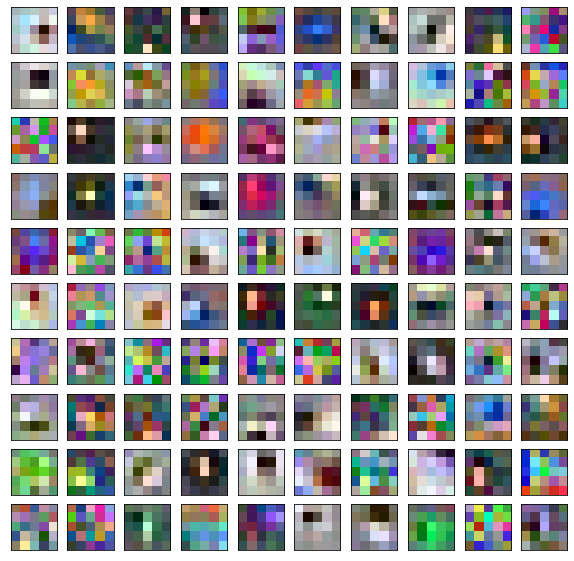

In [44]:
model.plot_filters("autoencoder")

Next we train a classifier using the pretrained weights from the autoencoder. The batch size is 128 and we train for 20 epochs with data augmentation (horizontal flip, 15% angle rotation and 10% vertical and horizontal shifts). We then evaluate the converged model on the test set.

In [46]:
history = model.train_classifier((x_train,y_train),(x_val,y_val), pretrained = True, batch_size = 128, epochs = 20, class_weight=None, data_augmentation=True)
test_results = model.evaluate_classifier(x_test,y_test,key="pretrained_classifier")

Epoch 1/20
185/185 [==============================] - 19s 102ms/step - loss: 1.7095 - acc: 0.3778 - val_loss: 1.4426 - val_acc: 0.4679
Epoch 2/20
185/185 [==============================] - 18s 95ms/step - loss: 1.4371 - acc: 0.4839 - val_loss: 1.2928 - val_acc: 0.5374
Epoch 3/20
185/185 [==============================] - 18s 100ms/step - loss: 1.2825 - acc: 0.5403 - val_loss: 1.1313 - val_acc: 0.6087
Epoch 4/20
185/185 [==============================] - 18s 98ms/step - loss: 1.1738 - acc: 0.5840 - val_loss: 1.1159 - val_acc: 0.6034
Epoch 5/20
185/185 [==============================] - 18s 99ms/step - loss: 1.1052 - acc: 0.6071 - val_loss: 0.9563 - val_acc: 0.6480
Epoch 6/20
185/185 [==============================] - 18s 100ms/step - loss: 1.0418 - acc: 0.6339 - val_loss: 0.9523 - val_acc: 0.6595
Epoch 7/20
185/185 [==============================] - 18s 99ms/step - loss: 1.0023 - acc: 0.6500 - val_loss: 1.0164 - val_acc: 0.6346
Epoch 8/20
185/185 [==============================] - 18s 9

Here we perform the same training as above, but this time we create a new classifier network without copying the weights from the autoencoder.

In [47]:
history = model.train_classifier((x_train,y_train),(x_val,y_val), pretrained = False, batch_size = 128, epochs = 20, class_weight=None, data_augmentation=True)
test_results = model.evaluate_classifier(x_test,y_test, key = "rand_init_classifier")

Epoch 1/20
185/185 [==============================] - 19s 103ms/step - loss: 1.7090 - acc: 0.3773 - val_loss: 1.4643 - val_acc: 0.4479
Epoch 2/20
185/185 [==============================] - 17s 92ms/step - loss: 1.4152 - acc: 0.4925 - val_loss: 1.3268 - val_acc: 0.5392
Epoch 3/20
185/185 [==============================] - 17s 94ms/step - loss: 1.2814 - acc: 0.5437 - val_loss: 1.1738 - val_acc: 0.5731
Epoch 4/20
185/185 [==============================] - 17s 91ms/step - loss: 1.1873 - acc: 0.5810 - val_loss: 1.1325 - val_acc: 0.6025
Epoch 5/20
185/185 [==============================] - 17s 92ms/step - loss: 1.1154 - acc: 0.6083 - val_loss: 0.9724 - val_acc: 0.6640
Epoch 6/20
185/185 [==============================] - 17s 93ms/step - loss: 1.0497 - acc: 0.6294 - val_loss: 0.9846 - val_acc: 0.6381
Epoch 7/20
185/185 [==============================] - 17s 90ms/step - loss: 1.0117 - acc: 0.6433 - val_loss: 0.9324 - val_acc: 0.6613
Epoch 8/20
185/185 [==============================] - 17s 91m

Finally, in the following code block we repeat the experiment 10 times and store the model weights as well as the evaluation results.

In [0]:
os.makedirs("model_weights/pretrained_classifier")
os.makedirs("model_weights/rand_init_classifier")
os.makedirs("model_weights/autencoder")

In [0]:
histories = {"autoencoder":[],
             "pretrained_classifier":[],
             "rand_init_classifier":[]}

results = {"pretrained_classifier":[],
             "rand_init_classifier":[]}

epochs = 20
batch_size = 128

for n in range(10):
    print(f"Experiment {n+1}/{10}")
    model = CAE_classifier(input_shape)

    history = model.train_autoencoder(x_train,x_val, epochs = epochs, batch_size = 65, verbose = 0)
    model.autoencoder.save_weights("model_weights/autencoder/weights_" + str(n))
    histories["autoencoder"].append(history)

    history = model.train_classifier((x_train,y_train),(x_val,y_val), pretrained = True, data_augmentation=True,batch_size = batch_size, epochs = epochs, verbose = 0)
    model.pretrained_classifier.save_weights("model_weights/pretrained_classifier/weights_" + str(n))
    result = model.evaluate_classifier(x_test,y_test, key = "pretrained_classifier")
    histories["pretrained_classifier"].append(history)
    results["pretrained_classifier"].append(result)

    history = model.train_classifier((x_train,y_train),(x_val,y_val), pretrained = False, data_augmentation=True, batch_size = batch_size, epochs = epochs, verbose = 0)
    model.rand_init_classifier.save_weights("model_weights/rand_init_classifier/weights_" + str(n))
    result = model.evaluate_classifier(x_test,y_test, key = "rand_init_classifier")
    histories["rand_init_classifier"].append(history)
    results["rand_init_classifier"].append(result)

print(results)


Experiment 1/10
79/79 [==============================] - 1s 12ms/step
Accuracy of pretrained_classifier on test data is 74.12%
79/79 [==============================] - 1s 11ms/step
Accuracy of rand_init_classifier on test data is 73.70%
Experiment 2/10
79/79 [==============================] - 1s 11ms/step
Accuracy of pretrained_classifier on test data is 72.58%
79/79 [==============================] - 1s 11ms/step
Accuracy of rand_init_classifier on test data is 74.12%
Experiment 3/10
79/79 [==============================] - 1s 11ms/step
Accuracy of pretrained_classifier on test data is 73.46%
79/79 [==============================] - 1s 12ms/step
Accuracy of rand_init_classifier on test data is 70.56%
Experiment 4/10
79/79 [==============================] - 1s 11ms/step
Accuracy of pretrained_classifier on test data is 72.54%
